In [27]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [29]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_train.pth'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module8/exercise/y_train.pth'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_test.pth'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'X_train.pth')
download_file(data_train_labels_url, 'y_train.pth')
download_file(data_test_features_url, 'X_test.pth')

KeyboardInterrupt: 

In [165]:
import torch

# Load the saved tensors
X = torch.load('X_train.pth')
y = torch.load('y_train.pth')

# Print shapes to verify the data
print("Dataset shapes:")
print(f"X_train: {X.shape}")  # Should be torch.Size([60000, 28, 28])
print(f"y_train: {y.shape}")  # Should be torch.Size([60000])

# Example: access the first image and its label
first_image = X[0]
first_label = y[0]

print(f"\nFirst image shape: {first_image.shape}")  # Should be torch.Size([28, 28])
print(f"First image label: {first_label}")         # Should be a number between 0-9

Dataset shapes:
X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])

First image shape: torch.Size([3, 32, 32])
First image label: 6


In [36]:
def plot_images(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)
    
    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])
    
    # Plot each example
    for i in range(num_examples):
        # Get the image
        img = np.array(X[i]).astype(int)
        
        # If the image has 3 dimensions, transpose it to (height, width, channels)
        if img.ndim == 3 and img.shape[0] == 3:  # Shape is (3, height, width)
            img = np.transpose(img, (1, 2, 0))  # Convert to (height, width, channels)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

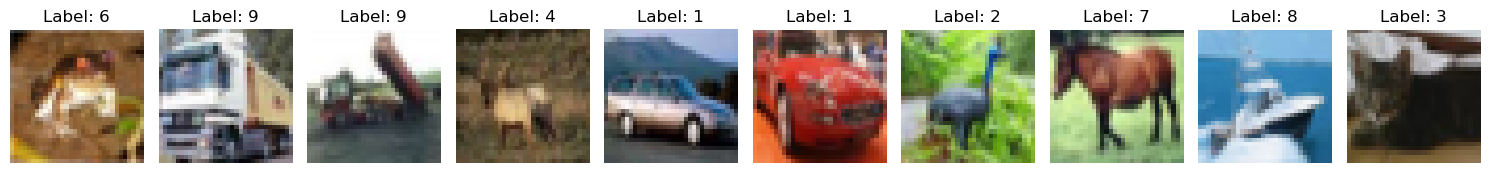

In [38]:
# Plot some examples
fig = plot_images(X, y, num_examples=10)
plt.show()

In [55]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [167]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Scale features
    num_samples, _ , height, width = X.shape
    X_reshaped = X.reshape(num_samples, -1)  # Flatten for scaling
    scaler = StandardScaler()
    X_scaled_flat = scaler.fit_transform(X_reshaped)  # Scale features
    X_scaled = X_scaled_flat.reshape(num_samples, 3, height, width)  # Reshape with channel dimension
    
    X_trainval,X_test,y_trainval,y_test = train_test_split(X_scaled,y,test_size = 1-train_size-val_size,random_state=random_state)
    X_train,X_val,y_train,y_val = train_test_split(X_trainval,y_trainval,test_size = val_size/(val_size+train_size),random_state = random_state)

    data_loader_train = DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=batch_size, shuffle=True,drop_last=True)
    data_loader_val = DataLoader(
        TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=batch_size,drop_last=True)
    data_loader_test = DataLoader(
        TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
        batch_size=batch_size)
    return data_loader_train, data_loader_val, data_loader_test

In [143]:
def create_model(device):
    model = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),  

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.Linear(256, 10)
    ).to(device)
    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Define optimizer with improved parameters
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    return model, criterion, optimizer

## Train

In [135]:
from collections import defaultdict
import torch

In [169]:
data_loader_train, data_loader_val, data_loader_test = preprocess_data(X,y)

In [131]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [201]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=7, device='cpu',checkpoint_path='checkpoint.pt'):
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)
    history = defaultdict(list)
    for epoch in range(num_epochs):
        model.train()
        train_loss,train_correct,total_train=0.0,0,0
        for X_train_batch,y_train_batch in train_loader:
            X_train_batch,y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
            optimizer.zero_grad()
            output = model(X_train_batch)
            loss = criterion(output,y_train_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*X_train_batch.size(0)
            _,pred = torch.max(output,1)
            train_correct += (pred==y_train_batch).sum().item()
            total_train += y_train_batch.size(0) 
        train_loss /= total_train
        train_acc = train_correct / total_train 

        model.eval()
        eval_loss,eval_correct,total_eval=0.0,0,0
        with torch.no_grad():
            for X_eval_batch,y_eval_batch in val_loader:
                X_eval_batch,y_eval_batch = X_eval_batch.to(device),y_eval_batch.to(device)
                output = model(X_eval_batch)
                loss = criterion(output,y_eval_batch)

                eval_loss += loss.item()*X_eval_batch.size(0)
                _,pred = torch.max(output,1)
                eval_correct += (pred==y_eval_batch).sum().item()
                total_eval += y_eval_batch.size(0)

        eval_loss /= total_eval
        eval_acc = eval_correct / total_eval

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(eval_loss)
        history['eval_acc'].append(eval_acc)

         # 打印每个 epoch 的结果
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {eval_loss:.4f}, Val Acc: {eval_acc:.4f}\n")
        
        early_stopping(eval_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. recharge le meilleur modele.")
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            break
        
    return history

In [228]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Create model and training components
model, criterion, optimizer = create_model(device)

# Train the model
history = train_model(
    model=model,
    train_loader=data_loader_train,
    val_loader=data_loader_val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device
)

Epoch 1/20
Train Loss: 1.5597, Train Acc: 0.4406
Val Loss: 1.1432, Val Acc: 0.5883

Validation loss decreased (inf --> 1.143153). Saving model ...
Epoch 2/20
Train Loss: 1.2869, Train Acc: 0.5402
Val Loss: 0.9757, Val Acc: 0.6571

Validation loss decreased (1.143153 --> 0.975699). Saving model ...
Epoch 3/20
Train Loss: 1.1461, Train Acc: 0.5963
Val Loss: 0.8778, Val Acc: 0.6896

Validation loss decreased (0.975699 --> 0.877764). Saving model ...
Epoch 4/20
Train Loss: 1.0731, Train Acc: 0.6230
Val Loss: 0.8377, Val Acc: 0.7050

Validation loss decreased (0.877764 --> 0.837734). Saving model ...
Epoch 5/20
Train Loss: 1.0001, Train Acc: 0.6500
Val Loss: 0.8068, Val Acc: 0.7154

Validation loss decreased (0.837734 --> 0.806755). Saving model ...
Epoch 6/20
Train Loss: 0.9509, Train Acc: 0.6662
Val Loss: 0.7744, Val Acc: 0.7241

Validation loss decreased (0.806755 --> 0.774351). Saving model ...
Epoch 7/20
Train Loss: 0.9059, Train Acc: 0.6804
Val Loss: 0.7346, Val Acc: 0.7429

Validatio

In [252]:
X_test = torch.load('X_test.pth')
X_test = X_test.to(device)
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(X_test)  
    predictions = torch.argmax(outputs, dim=1) 

In [254]:
predictions = predictions.cpu().numpy()#让张量从gpu回到cpu并变成numpy数组以进行df操作，numpy只能处理cpu张量
submission = pd.DataFrame({
    'label': predictions # your_prediction
})
submission.index.name = 'index'
submission.to_csv('submission.csv', index=True, sep=',')
submission.head()

,label
index,
0,0
1,1
2,9
3,0
4,8
